In [2]:
# General Libraries
import numpy as np
import pandas as pd
import ast
import random
from collections import defaultdict
from tqdm import tqdm
import time
import faiss

# Torch
import torch 
from torch.utils.data import DataLoader, random_split 
from torch.optim.lr_scheduler import ReduceLROnPlateau 

# SBERT
from sentence_transformers import SentenceTransformer, InputExample, LoggingHandler, losses, util, SentencesDataset 
from sentence_transformers.losses import TripletLoss
from sentence_transformers.util import batch_to_device, cos_sim 

# sklearn
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt



In [3]:
import warnings
warnings.filterwarnings("ignore")

# Cleaning DataSet

In [6]:
# Load Dataset
df = pd.read_csv("C:\MovieReommenderSystem\TMDB_movie_dataset_v11.csv")
print(f"Number of movies in the dataset: {len(df)}")

Number of movies in the dataset: 1193898


In [ ]:
# Drop movies with missing overviews (descriptions)
df = df.dropna(subset=['overview'])

# Fill missing genres with "Unknown"
df['genres'] = df['genres'].fillna("Unknown")

# Drop movies without titles
df = df.dropna(subset=['title'])


In [ ]:
# Drop duplicate movies, keeping the first occurrence
df = df.drop_duplicates(subset=['title'], keep='first')
print(f"Remaining movies after removing duplicates: {len(df)}")

Remaining movies after removing duplicates: 798029


In [7]:
def process_genres(genre_data):
    if isinstance(genre_data, str):
        try:
            # Try parsing JSON format
            genre_list = ast.literal_eval(genre_data)
            return [genre['name'] for genre in genre_list if isinstance(genre, dict)]
        except (SyntaxError, ValueError):
            # If it's a plain comma-separated string, split it into a list
            return genre_data.split(", ")
    return []  # Return an empty list if there's no valid data

# Apply the function to the genres column
df['genres'] = df['genres'].apply(process_genres)

In [14]:
# Verify the changes
print(df[['title', 'genres']].sample(10))

                                  title                genres
317087        Revolt of the Mercenaries  [Adventure, Romance]
331402         Champagner für Zimmer 17     [Crime, Thriller]
369419                              ANU    [Adventure, Drama]
635112                        Who Is It               [Music]
1133952            The Green-Eyed Devil               [Drama]
1181833        Herbie Mann: Jasil Brazz                    []
34251                      Casanova Cat           [Animation]
513417            Les Tambours de Tokyo                    []
1045478  Cream Filled Chocolate Holes 2                    []
50387                    Exit Marrakech               [Drama]


In [21]:
df.to_csv("C:\MovieReommenderSystem\TMDB_movie_dataset_v12.csv", index=False)

# DataSet

In [22]:
# Load The Cleaned Dataset
df = pd.read_csv("C:\MovieReommenderSystem\TMDB_movie_dataset_v12.csv")

In [23]:
print(f"Remaining movies after removing duplicates: {len(df)}")

Remaining movies after removing duplicates: 798029


# Create Triplits for SBERT Fine-Tuning

In [ ]:
# 1️⃣ Load and Clean Dataset
df = pd.read_csv(r"C:\MovieReommenderSystem\TMDB_movie_dataset_v12.csv")
df = df[df["overview"].notna()]
df = df[df["overview"].str.len() > 100]
df = df.drop_duplicates(subset="overview")

# 2️⃣ NSFW Filtering
nsfw_keywords = [
    'xxx', 'porn', 'escort', 'call girl', 'hardcore', 'nude', 'sex', 'slut', 'babe',
    'cock', 'milf', 'pounded', 'oral', 'fetish', 'suck', 'jerk', 'cum', 'nsfw',
    'panties', 'blowjob', 'fucking', 'fuck', 'felatio', 'nasty', 'nipple', 'vibrator',
    'thagson', 'dildo', 'erotic', 'lust', 'orgasm', 'squirt', 'rape', 'raped', 'raping'
]
def is_nsfw(text):
    return any(word in text.lower() for word in nsfw_keywords)
df = df[~df["overview"].apply(is_nsfw)].reset_index(drop=True)
print(f"✅ Dataset cleaned: {len(df)} entries remain after NSFW filtering.")

# 3️⃣ Sample ~100k plots (helps us generate more than 35k triplets)
df_sample = df.sample(n=min(100000, len(df)), random_state=42).reset_index(drop=True)
plots = df_sample["overview"].tolist()

# 4️⃣ SBERT Embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
print("🔄 Encoding plots with SBERT...")
embeddings = model.encode(plots, batch_size=64, convert_to_numpy=True, show_progress_bar=True)

# 5️⃣ Normalize for cosine similarity
normalized_embeddings = normalize(embeddings, axis=1)

# 6️⃣ FAISS Index for fast similarity search
dimension = normalized_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(normalized_embeddings)

# 7️⃣ Generate Triplets
triplets = []
skipped = 0

print("🚀 Generating triplets...")
for i in tqdm(range(len(df_sample)), desc="🔍 Filtering Triplets"):
    anchor_idx = i
    anchor_vec = normalized_embeddings[anchor_idx].reshape(1, -1)

    # Top 20 similar indices (exclude self)
    _, I = index.search(anchor_vec, 21)
    similar_indices = I[0][1:]

    # Find valid positive
    selected_positive = None
    for pos_idx in similar_indices:
        sim_score = cosine_similarity(anchor_vec, normalized_embeddings[pos_idx].reshape(1, -1))[0][0]
        if sim_score > 0.60:
            selected_positive = pos_idx
            break
    if selected_positive is None:
        skipped += 1
        continue

    # Find valid negative
    selected_negative = None
    for _ in range(10):
        neg_idx = random.randint(0, len(df_sample) - 1)
        if neg_idx in [anchor_idx, selected_positive]:
            continue
        sim_score = cosine_similarity(anchor_vec, normalized_embeddings[neg_idx].reshape(1, -1))[0][0]
        if sim_score < 0.45:
            selected_negative = neg_idx
            break
    if selected_negative is None:
        skipped += 1
        continue

    # Append triplet
    triplets.append([
        plots[anchor_idx],
        plots[selected_positive],
        plots[selected_negative]
    ])

    # 💡 Stop at 50,000 triplets max
    if len(triplets) >= 50000:
        break

# 8️⃣ Save Triplets
triplet_df = pd.DataFrame(triplets, columns=["anchor", "positive", "negative"])
triplet_df.to_csv("expanded_triplet_dataset_v2.csv", index=False)

print(f"\n✅ Generated {len(triplets)} high-quality triplets")
print(f"❌ Skipped {skipped} anchors with no valid match")
print("💾 Saved as 'expanded_triplet_dataset.csv_v2'")


# Check Training Data

In [ ]:
# Load the dataset
df = pd.read_csv(r"C:\MovieReommenderSystem\expanded_triplet_dataset_v2.csv")

# 1. Check basic structure
print("🧾 Dataset shape:", df.shape)
print("📋 Columns:", df.columns.tolist())

# 2. Show first few rows
print("\n🔍 Sample data:")
print(df.head(5))

# 3. Check for null or empty entries
print("\n🚨 Null values per column:")
print(df.isnull().sum())

# 4. Check if any rows have duplicate triplets
duplicates = df.duplicated()
print(f"\n🔁 Duplicate rows: {duplicates.sum()}")

# 5. Check for overly short text
short_threshold = 50
print("\n🧼 Rows with short entries:")
short_rows = df[
    (df['anchor'].str.len() < short_threshold) |
    (df['positive'].str.len() < short_threshold) |
    (df['negative'].str.len() < short_threshold)
]
print(short_rows.shape)

# 6. Show one full triplet (nicely)
print("\n🎯 Example Triplet:\n")
example = df.iloc[0]
print("🔹 Anchor:\n", example['anchor'])
print("\n✅ Positive:\n", example['positive'])
print("\n❌ Negative:\n", example['negative'])

🧾 Dataset shape: (31511, 3)
📋 Columns: ['anchor', 'positive', 'negative']

🔍 Sample data:
                                              anchor  \
0  Francis, a depressive and nostalgic thirty-som...   
1  Where do we come from? Who are we? Where are w...   
2  Recounts a day in the life of Andrés who, due ...   
3  Budo Sento Championship 26 took place on Frida...   
4  A wealthy couple of Greek-Americans arrive in ...   

                                            positive  \
0  Drowning in debt, child support and bills all ...   
1  Where do I come From? What am I? Where am I go...   
2  Due to betting problems, Andrés and his lover,...   
3  Budo Sento Championship 23 took place Friday, ...   
4  A wealthy man is responsible for his friend’s ...   

                                            negative  
0  With the Men in Black on his case, fun-loving ...  
1  When Linda gets a phone call about her little ...  
2  Inspired by music films like Kanye West's Runa...  
3  Seung Jun wor

In [ ]:
# Function to show N random triplets nicely
def show_triplets(df, n=5):
    print(f"\n🎯 Showing {n} random triplets:\n" + "-"*60)
    samples = df.sample(n=n, random_state=random.randint(0, 10000)).reset_index(drop=True)

    for i, row in samples.iterrows():
        print(f"\n🟩 Triplet #{i+1}")
        print("\n🔹 Anchor:\n", row['anchor'])
        print("\n✅ Positive:\n", row['positive'])
        print("\n❌ Negative:\n", row['negative'])
        print("\n" + "-"*60)

# Call the function with however many samples to check
show_triplets(df, n=5)  # 👈 Change to 10, 20, etc. as needed


🎯 Showing 5 random triplets:
------------------------------------------------------------

🟩 Triplet #1

🔹 Anchor:
 A young female urologist opens an office in the same building as a male obstetrician. Eventually, they become entangled in a romance that allows them to grow and heal together.

✅ Positive:
 The romantic adventures of a 28-year-old gynecologist who has very little experience with women outside of the examining room.

❌ Negative:
 A humorous criminal story about a dog that knew how to read, appreciated classical music and spoke a foreign language. His primitive master hates his dog's superiority and tries to liquidate it physically.

------------------------------------------------------------

🟩 Triplet #2

🔹 Anchor:
 In the Christmas holidays, a mysterious extra-terrestrial force bursts into the life of a suburban couple on the brink of divorce. However, none of them notices this otherwordly presence, so this entity will have to live with them in this grey, sad and life

In [18]:
# Any missing (NaN) values?
print("🔍 Nulls per column:\n", df.isnull().sum())

# Any very short entries? (Less than 30 characters)
short_entries = df[
    (df["anchor"].str.len() < 30) |
    (df["positive"].str.len() < 30) |
    (df["negative"].str.len() < 30)
]
print(f"🧼 Short entries: {len(short_entries)}")

🔍 Nulls per column:
 anchor      0
positive    0
negative    0
dtype: int64
🧼 Short entries: 0


In [19]:
# Any duplicate triplets?
dupes = df.duplicated()
print(f"🔁 Duplicate rows: {dupes.sum()}")

# Any rows where anchor == positive or anchor == negative?
same_pos = df[df["anchor"] == df["positive"]]
same_neg = df[df["anchor"] == df["negative"]]

print(f"⚠️ Anchor == Positive: {len(same_pos)}")
print(f"⚠️ Anchor == Negative: {len(same_neg)}")

if len(same_pos) > 0:
    df = df[df["anchor"] != df["positive"]].reset_index(drop=True)
    print(f"✅ Final dataset shape after cleaning: {df.shape}")
    df.to_csv("expanded_triplet_dataset_v2.csv", index=False)

🔁 Duplicate rows: 0
⚠️ Anchor == Positive: 0
⚠️ Anchor == Negative: 0


In [20]:
# View a few random triplets
import random

for i in range(5):
    row = df.sample(n=1).iloc[0]
    print(f"\n🎯 Triplet #{i+1}")
    print("🔹 Anchor:\n", row['anchor'])
    print("✅ Positive:\n", row['positive'])
    print("❌ Negative:\n", row['negative'])


🎯 Triplet #1
🔹 Anchor:
 It is the love story of the cardenche singers in Sapioriz, Durango, Mexico, and the murder of Maria Cristina Salazar Olvera, one of their daugthers.
✅ Positive:
 A movie about Cardenche singing, which was born within the backdrop akin to slavery of the cotton laborers of Durango in the 19th century. A tradition hanging on by a thread.
❌ Negative:
 A 14-year-old junior high school boy who likes astronomy was forced to practice the piano by his single father. Suddenly an alien appeared in the boy's bedroom, which completely changed the lives of the boy and his father.

🎯 Triplet #2
🔹 Anchor:
 Sanna has broken up with her boyfriend Jon. Because her father is in the hospital, she moved into her father's apartment. In his dresser drawer, she finds clipped obituaries of his colleagues, who all seem to have died prematurely. Sanna crosses one border after another, approaching a total collapse of her obsession with truth. In the end, she takes the law into her own hand

In [23]:
model = SentenceTransformer("all-MiniLM-L6-v2")

sample = df.sample(n=1).iloc[0]
anchor_emb = model.encode(sample['anchor'], convert_to_tensor=True)
pos_emb = model.encode(sample['positive'], convert_to_tensor=True)
neg_emb = model.encode(sample['negative'], convert_to_tensor=True)

pos_sim = util.pytorch_cos_sim(anchor_emb, pos_emb).item()
neg_sim = util.pytorch_cos_sim(anchor_emb, neg_emb).item()

print(f"\n✅ Positive Similarity: {pos_sim:.4f}")
print(f"❌ Negative Similarity: {neg_sim:.4f}")
print(f"📉 Difference: {pos_sim - neg_sim:.4f}")



✅ Positive Similarity: 0.6372
❌ Negative Similarity: 0.0170
📉 Difference: 0.6201


In [41]:
diffs = []
for _ in range(10):
    sample = df.sample(n=1).iloc[0]
    anchor_emb = model.encode(sample['anchor'], convert_to_tensor=True)
    pos_emb = model.encode(sample['positive'], convert_to_tensor=True)
    neg_emb = model.encode(sample['negative'], convert_to_tensor=True)

    pos_sim = util.pytorch_cos_sim(anchor_emb, pos_emb).item()
    neg_sim = util.pytorch_cos_sim(anchor_emb, neg_emb).item()
    diffs.append(pos_sim - neg_sim)

print(f"📊 Avg Positive-Negative Difference: {np.mean(diffs):.4f}")


📊 Avg Positive-Negative Difference: 0.6196


# Fine-Tune SBERT

In [3]:
# 1. Load triplet dataset
df_Triplets = pd.read_csv(r"C:\MovieReommenderSystem\expanded_triplet_dataset_v2.csv")
print(f"✅ Total Training df_Triplets Saved: {len(df_Triplets)}")

✅ Total Training df_Triplets Saved: 31511


In [4]:
# 2. Convert dataset into SBERT InputExamples
train_samples = [InputExample(texts=[row['anchor'], row['positive'], row['negative']]) for _, row in df_Triplets.iterrows()]

In [5]:
# 3. Split into Training & Validation Set
train_size = int(0.9 * len(train_samples))  # 90% Train, 10% Validation
val_size = len(train_samples) - train_size
train_dataset, val_dataset = random_split(train_samples, [train_size, val_size])
print(f"📊 Training Samples: {len(train_dataset)} | Validation Samples: {len(val_dataset)}")

📊 Training Samples: 28359 | Validation Samples: 3152


In [6]:
# 4 Define collate function for triplet batching
def collate_fn(batch):
    anchors = [ex.texts[0] for ex in batch]
    positives = [ex.texts[1] for ex in batch]
    negatives = [ex.texts[2] for ex in batch]
    return anchors, positives, negatives

In [7]:
# ✅ Load Pretrained SBERT Model
model = SentenceTransformer("all-MiniLM-L6-v2")  # You can try larger models later --> another good one is "all-MiniLM-L6-v2"

# ✅ Move Model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"✅ Model loaded on {device}.")

✅ Model loaded on cuda.


In [8]:
# 6. Create DataLoaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=8, collate_fn=collate_fn)

# Add a margin (default is 1.0, but can be tuned into, e.g., 0.3 or 0.5)
train_loss = TripletLoss(model=model, triplet_margin=0.5)

# Print model details
print(model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


In [9]:
# 7. Fine-Tune Model for Multiple Epochs
epochs = 10 
for epoch in range(epochs):
    

    # 8. Train the model
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=1,  
        warmup_steps=100,
        optimizer_params={"lr": 5e-5},  # Learning rate
    )

    # Validation Loop
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for anchors, positives, negatives in val_dataloader:
            #  Tokenize batch (convert raw text into tensors)
            sentence_features = [
                model.tokenize(anchors),
                model.tokenize(positives),
                model.tokenize(negatives)
            ]

            #  Move tensors to the correct device (CPU/GPU)
            sentence_features = [batch_to_device(f, model.device) for f in sentence_features]

            #  Compute triplet loss using `forward()`
            loss = train_loss.forward(sentence_features, labels=None)
            total_val_loss += loss.item()

    #  Compute average validation loss
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"📊 Validation Loss: {avg_val_loss:.4f}")

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0101


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0096


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0101


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0098


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0106


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0115


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0121


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0106


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0107


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3545 [00:00<?, ?it/s]

📊 Validation Loss: 0.0107


In [5]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 22,713,216
Trainable parameters: 22,713,216


In [12]:
anchor = "A detective investigates a series of brutal murders."
positive = "A police officer uncovers a shocking serial killer case."
negative = "A group of friends go on a vacation to Hawaii."

anchor_emb = model.encode(anchor, convert_to_tensor=True)
positive_emb = model.encode(positive, convert_to_tensor=True)
negative_emb = model.encode(negative, convert_to_tensor=True)

pos_sim = util.pytorch_cos_sim(anchor_emb, positive_emb).item()
neg_sim = util.pytorch_cos_sim(anchor_emb, negative_emb).item()

print(f"✅ Positive Similarity: {pos_sim:.4f}")
print(f"❌ Negative Similarity: {neg_sim:.4f}")


✅ Positive Similarity: 0.9430
❌ Negative Similarity: -0.0955


In [13]:
# Evaluate_Triplet_Accuracy(model, val_dataset)
def evaluate_triplet_accuracy(model, dataset):
    correct = 0
    total = len(dataset)

    for ex in dataset:
        anchor, positive, negative = ex.texts

        anchor_emb = model.encode(anchor, convert_to_tensor=True)
        pos_emb = model.encode(positive, convert_to_tensor=True)
        neg_emb = model.encode(negative, convert_to_tensor=True)

        if cos_sim(anchor_emb, pos_emb) > cos_sim(anchor_emb, neg_emb):
            correct += 1

    accuracy = (correct / total) * 100
    print(f"\n✅ Model Accuracy: {accuracy:.2f}% on {total} validation triplets")

# Evaluate the model
evaluate_triplet_accuracy(model, val_dataset)


✅ Model Accuracy: 99.94% on 3152 validation triplets


In [ ]:
# Evaluate Embedding Quality
for _ in range(5):
    row = df_Triplets.sample(1).iloc[0]
    anchor_emb = model.encode(row['anchor'], convert_to_tensor=True)
    pos_emb = model.encode(row['positive'], convert_to_tensor=True)
    neg_emb = model.encode(row['negative'], convert_to_tensor=True)

    pos_sim = cos_sim(anchor_emb, pos_emb).item()
    neg_sim = cos_sim(anchor_emb, neg_emb).item()
    print(f"✅ Positive Similarity: {pos_sim:.4f} | ❌ Negative Similarity: {neg_sim:.4f} | 📉 Diff: {pos_sim - neg_sim:.4f}")

✅ Positive Similarity: 0.8612 | ❌ Negative Similarity: 0.0175 | 📉 Diff: 0.8437
✅ Positive Similarity: 0.8882 | ❌ Negative Similarity: -0.0880 | 📉 Diff: 0.9762
✅ Positive Similarity: 0.9038 | ❌ Negative Similarity: -0.0963 | 📉 Diff: 1.0001
✅ Positive Similarity: 0.9316 | ❌ Negative Similarity: 0.0314 | 📉 Diff: 0.9002
✅ Positive Similarity: 0.8161 | ❌ Negative Similarity: 0.0473 | 📉 Diff: 0.7688


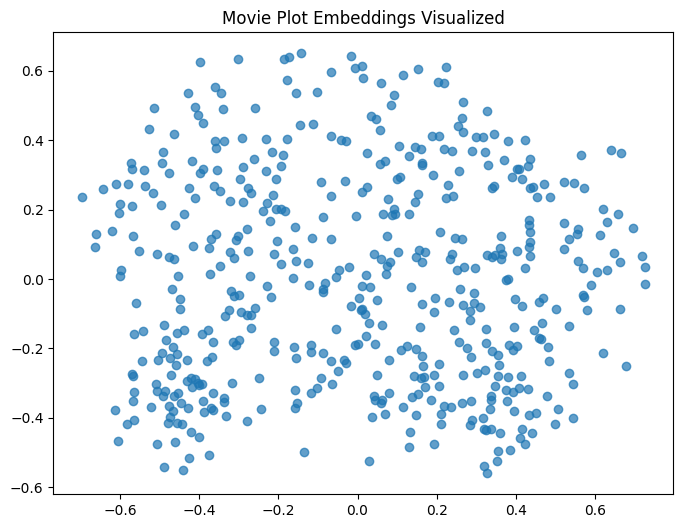

In [ ]:
# Visualize Embedding Space
embs = model.encode(df_Triplets['anchor'].tolist()[:500])
reduced = PCA(n_components=2).fit_transform(embs)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.7)
plt.title("Movie Plot Embeddings Visualized")
plt.show()

In [ ]:
model.save("C:\MovieReommenderSystem\SBERT_Movie_Recommender_v1")

# Embedding Vectros

In [17]:
# Load the Dataset
df_movies = pd.read_csv("C:\MovieReommenderSystem\TMDB_movie_dataset_v12.csv")
print(f"Movie Count: {len(df_movies)}")

Movie Count: 798029


In [58]:
# Load the Fine-Tuned Model
model = SentenceTransformer("C:\MovieReommenderSystem\SBERT_Movie_Recommender_v1")

# ✅ Move Model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"✅ Model loaded on {device}.")

✅ Model loaded on cuda.


In [ ]:
# Encode all overviews
print(f"🔄 Encoding {len(df_movies)} movie plots...")
movie_embeddings = model.encode(
    df_movies["overview"].tolist(),
    batch_size=16,
    show_progress_bar=True,
    convert_to_numpy=True
)

print("✅ Embeddings complete!")

🔄 Encoding 798029 movie plots...
✅ Embeddings complete!


In [7]:
# Normalize embeddings for cosine similarity
movie_embeddings = normalize(movie_embeddings, norm='l2', axis=1)

In [9]:
# Save the embeddings
np.save("movie_embeddings.npy", movie_embeddings)
print("✅ Embeddings saved to 'movie_embeddings.npy'")

✅ Embeddings saved to 'movie_embeddings.npy'


In [10]:
# Load the embeddings
movie_embeddings = np.load("movie_embeddings.npy")
print("✅ Embeddings loaded! Shape:", movie_embeddings.shape)

✅ Embeddings loaded! Shape: (798029, 384)


# Building FIASS

In [12]:
# Build the index
dimension = movie_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner product = cosine similarity if vectors are normalized
index.add(movie_embeddings)

print(f"🎯 FAISS index built with {index.ntotal} embeddings.")

🎯 FAISS index built with 798029 embeddings.


In [14]:
faiss.write_index(index, "movie_index.faiss")
np.save("movie_embeddings.npy", movie_embeddings)

In [15]:
# Load the FAISS index
index = faiss.read_index("movie_index.faiss")    # Index file saved earlier

# Recommendation System

In [4]:
# 1. Load fine-tuned model
model = SentenceTransformer("C:\MovieReommenderSystem\SBERT_Movie_Recommender_v1")

# ✅ Move Model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"✅ Model loaded on {device}.")

✅ Model loaded on cuda.


In [5]:
# 2. Load movie metadata and embeddings
df = pd.read_csv("C:\MovieReommenderSystem\TMDB_movie_dataset_v12.csv")
movie_embeddings = np.load("C:\MovieReommenderSystem\movie_embeddings.npy") # Embeddings saved earlier

In [8]:
# 3. Load the FAISS index
index = faiss.read_index(r"C:\Users\movie-recommender\indexes\movie_index.faiss") # Index file saved earlier

In [9]:
def detect_franchise(title, overview):
    # 🎬 Franchise Keywords for Matching
    franchise_keywords = {

        "Marvel": [
            "avengers", "iron man", "captain america", "thor", "hulk", "black widow", "ant-man", "black panther", 
            "spider-man", "dr. strange", "doctor strange", "shang-chi", "guardians of the galaxy", "eternals", 
            "wanda", "marvel", "ms. marvel", "falcon", "winter soldier", "multiverse", "kang", "loki"
        ],
        "DC": [
            "batman", "superman", "wonder woman", "aquaman", "flash", "justice league", "suicide squad", 
            "joker", "shazam", "black adam", "dc", "zatanna", "cyborg", "green lantern", "penguin", "Man of Steel", "Superman"
        ],
        "Harry Potter": [
            "harry potter", "hogwarts", "voldemort", "dumbledore", "hermione", "ron weasley", 
            "fantastic beasts", "grindelwald", "quidditch", "slytherin", "gryffindor", "hufflepuff", "ravenclaw"
        ],
        "Lord of the Rings": [
            "lord of the rings", "frodo", "gandalf", "aragorn", "middle earth", "sauron", 
            "legolas", "hobbit", "bilbo", "tolkien", "elrond", "mordor"
        ],
        "Star Wars": [
            "star wars", "skywalker", "darth vader", "yoda", "jedi", "sith", "death star", 
            "grogu", "mandalorian", "obi-wan", "kenobi", "dooku", "padmé", "anakin", "rey", "bb-8", "galactic empire"
        ],
        "Fast & Furious": [
            "fast and furious", "fast & furious", "dom toretto", "vin diesel", "furious", "f9", "fast x", 
            "tokyo drift", "ludacris", "hobs and shaw"
        ],
        "Transformers": [
            "transformers", "bumblebee", "optimus prime", "megatron", "autobot", "decepticon", 
            "rise of the beasts"
        ],
        "Twilight": [
            "twilight", "edward cullen", "bella swan", "jacob black", "vampire", "werewolf", "breaking dawn"
        ],
        "The Hunger Games": [
            "hunger games", "katniss everdeen", "peeta", "panem", "district", "catching fire", "mockingjay", "snow"
        ],
        "James Bond": [
            "james bond", "007", "spectre", "quantum of solace", "skyfall", "casino royale", 
            "no time to die", "moneypenny", "q", "mi6"
        ],
        "Pirates of the Caribbean": [
            "pirates of the caribbean", "jack sparrow", "black pearl", "davy jones", 
            "will turner", "elizabeth swann", "barbossa"
        ],
        "Mission: Impossible": [
            "mission impossible", "ethan hunt", "imf", "ghost protocol", "rogue nation", "fallout", 
            "dead reckoning"
        ],
        "John Wick": [
            "john wick", "continental", "baba yaga", "high table", "dog", "assassin"
        ],
        "The Matrix": [
            "matrix", "neo", "trinity", "morpheus", "agent smith", "zion", "red pill", "blue pill"
        ],
        "Despicable Me": [
            "despicable me", "minions", "gru", "agnès", "vector", "gru jr"
        ],
        "Shrek": [
            "shrek", "donkey", "fiona", "far far away", "puss in boots", "lord farquaad"
        ],
        "Frozen": [
            "frozen", "elsa", "anna", "olaf", "arendelle", "let it go"
        ],
        "Cars": [
            "cars", "lightning mcqueen", "mater", "radiator springs", "doc hudson"
        ],
        "Jurassic Park": [
            "jurassic park", "jurassic world", "raptor", "velociraptor", "t-rex", "indominus", 
            "dr. grant", "ian malcolm", "claire dearing"
        ],
    }
    
    # Normalize keywords to lowercase for reliable matching
    franchise_keywords = {
        franchise: [kw.lower() for kw in keywords]
        for franchise, keywords in franchise_keywords.items()
    }

    text = (title + " " + overview).lower()

    matches = {}
    for franchise, keywords in franchise_keywords.items():
        for keyword in keywords:
            if keyword in text:
                matches[franchise] = matches.get(franchise, 0) + 1

    if not matches:
        return "Unknown"

    # Return the franchise with the most matches
    return max(matches, key=matches.get)

df['franchise'] = df.apply(lambda row: detect_franchise(row['title'], row['overview']), axis=1)
print("🎬 Franchise Detection Complete!")

🎬 Franchise Detection Complete!


In [10]:
def recommend(query, use_movie_name=True, top_k=10,
              filter_by_nsfw=True,
              filter_by_franchise=False,
              filter_by_genre=False):
    
    # Get input embedding
    if use_movie_name:
        movie_row = df[df["title"].str.lower() == query.lower()]
        if movie_row.empty:
            return []
        movie_row = movie_row.iloc[0]
        overview = movie_row["overview"]
        input_emb = model.encode(overview, convert_to_tensor=True)
        detected_franchise = detect_franchise(movie_row["title"], overview)
        input_genres = set(movie_row["genres"]) if isinstance(movie_row["genres"], list) else set()
        if "Unknown" in input_genres:
            input_genres = set()
    else:
        overview = query
        input_emb = model.encode(overview, convert_to_tensor=True)
        detected_franchise = detect_franchise("", overview)
        input_genres = set()  # can't filter genres from free text

    # FAISS Search
    input_emb_np = input_emb.cpu().detach().numpy().reshape(1, -1)
    _, indices = index.search(input_emb_np, top_k * 20)
    faiss_results = df.iloc[indices[0]].copy()
    faiss_embeddings = movie_embeddings[indices[0]]

    # Re-rank by similarity and popularity
    sims = cos_sim(input_emb, torch.tensor(faiss_embeddings).to(input_emb.device)).squeeze().tolist()
    popularity = faiss_results["popularity"].fillna(0).values
    rerank_score = [sim * np.log1p(pop) for sim, pop in zip(sims, popularity)]
    faiss_results["score"] = rerank_score

    # Franchise Filter
    if filter_by_franchise and detected_franchise != "Unknown":
        faiss_results["franchise"] = faiss_results.apply(
            lambda row: detect_franchise(row["title"], row["overview"]), axis=1)
        faiss_results = faiss_results[faiss_results["franchise"] == detected_franchise]

    # Genre Filter
    if filter_by_genre and input_genres:
        def genre_overlap(g):
            if isinstance(g, list) and "Unknown" not in g:
                return len(input_genres & set(g))
            return 0  # allow unknown genres, they just get 0 overlap
        faiss_results["genre_overlap"] = faiss_results["genres"].apply(genre_overlap)
        faiss_results = faiss_results[faiss_results["genre_overlap"] >= 2]


    # Remove input movie from results
    if use_movie_name:
        faiss_results = faiss_results[faiss_results["title"].str.lower() != query.lower()]

    # Final top-k nicely formatted DataFrame
    top_results = faiss_results.sort_values(by="score", ascending=False).head(top_k)
    
    # Ensure 'franchise' exists before returning
    if "franchise" not in top_results.columns:
        top_results["franchise"] = "Unknown"

    return top_results[["title", "genres", "franchise", "popularity", "id"]].reset_index(drop=True)

In [12]:
recommend("Saving Private Ryan", use_movie_name=True, filter_by_franchise=False, filter_by_genre=False, top_k=10)

,title,genres,franchise,popularity,id
0,Bunker,"['Horror', 'Thriller', 'War']",Unknown,339.829,1032666
1,Warhorse One,"['Action', 'Drama', 'War']",Unknown,230.210,1076487
2,Wrong Turn 2: Dead End,"['Horror', 'Thriller']",Unknown,50.162,13186
3,1917,"['War', 'History', 'Thriller']",Unknown,44.356,530915
4,Greyhound,"['War', 'Action', 'Drama']",Star Wars,23.324,516486
5,The Guns of Navarone,"['War', 'Action', 'Adventure']",Unknown,21.499,10911
6,WarHunt,"['Action', 'Horror', 'Thriller', 'War', 'Fanta...",James Bond,20.925,697799
7,Soldier,"['Science Fiction', 'Action']",Unknown,18.605,9425
8,Gallipoli,"['War', 'History', 'Drama']",Unknown,13.874,11646
9,Hell's Angels,"['Drama', 'War', 'Action']",Unknown,10.922,22301


In [12]:
recommend("Avengers: endgame", use_movie_name=True, filter_by_franchise=True, filter_by_genre=True, top_k=5)

,title,genres,franchise,popularity,id
0,Avengers: Infinity War,"['Adventure', 'Action', 'Science Fiction']",Marvel,154.340,299536
1,Avengers: Age of Ultron,"['Action', 'Adventure', 'Science Fiction']",Marvel,96.565,99861
2,Captain America: Civil War,"['Adventure', 'Action', 'Science Fiction']",Marvel,70.741,271110
3,Thor: The Dark World,"['Action', 'Adventure', 'Fantasy']",Marvel,59.968,76338
4,Captain Marvel,"['Action', 'Adventure', 'Science Fiction']",Marvel,50.399,299537


In [10]:
recommend("John Wick", use_movie_name=True, filter_by_genre=False, filter_by_franchise=False, top_k=10)

,title,genres,franchise,popularity,id
0,John Wick: Chapter 4,"['Action', 'Thriller', 'Crime']",John Wick,482.538,603692
1,John Wick: Chapter 2,"['Action', 'Thriller', 'Crime']",John Wick,88.285,324552
2,John Wick: Chapter 3 - Parabellum,"['Action', 'Thriller', 'Crime']",John Wick,80.825,458156
3,Live Free or Die Hard,"['Action', 'Thriller']",Unknown,33.523,1571
4,Snitch,"['Thriller', 'Drama', 'Action']",Unknown,26.369,134411
5,Lord of the Streets,['Action'],Unknown,23.303,965839
6,Stripes,"['Action', 'Comedy']",Unknown,19.950,10890
7,Marked for Death,"['Action', 'Crime']",James Bond,18.504,10173
8,Last Man Standing,"['Crime', 'Action', 'Western']",Unknown,14.621,9333
9,Rumble Fish,"['Crime', 'Drama']",Unknown,15.191,232


In [11]:
recommend("A young Jedi confronts the dark side, as rebels launch a final attack on the Empires new Death Star.", use_movie_name=False, filter_by_franchise=False, filter_by_genre=True, top_k=10)

,title,genres,franchise,popularity,id
0,Return of the Jedi,"['Adventure', 'Action', 'Science Fiction']",Star Wars,40.104,1892
1,Star Wars: The Force Awakens,"['Adventure', 'Action', 'Science Fiction']",Star Wars,66.772,140607
2,Star Wars: Episode III - Revenge of the Sith,"['Adventure', 'Action', 'Science Fiction']",Star Wars,41.215,1895
3,Mortal Kombat: Annihilation,"['Action', 'Fantasy', 'Science Fiction']",Unknown,31.851,9823
4,Star Wars: Episode I - The Phantom Menace,"['Adventure', 'Action', 'Science Fiction']",Star Wars,46.845,1893
5,The Empire Strikes Back,"['Adventure', 'Action', 'Science Fiction']",Star Wars,35.265,1891
6,The Old Guard,"['Action', 'Fantasy']",Unknown,19.808,547016
7,Pretty Guardian Sailor Moon Cosmos The Movie P...,['Animation'],Unknown,19.515,968868
8,Vikingdom,['Adventure'],Unknown,11.106,100542
9,RE:BORN,"['Action', 'Crime']",Unknown,12.632,408866


In [23]:
import pandas as pd
import ast

# convert stringified lists to actual Python lists
def parse_genres(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except:
        return []

df["genres"] = df["genres"].apply(parse_genres)


# Anvil

In [24]:
import anvil.server

anvil.server.connect("server_HGQ7XT54EJ2WECY25HCQSMRF-CBCKNDJYZVRIVQRL")

In [25]:
@anvil.server.callable
def get_recommendations(
    query,
    use_movie_name=True,
    top_k=10,
    filter_by_franchise=False,
    filter_by_genre=False,
):
    try:
        results = recommend(
            query,
            use_movie_name=use_movie_name,
            top_k=top_k,
            filter_by_franchise=filter_by_franchise,
            filter_by_genre=filter_by_genre,
            
        )
        return results.to_dict(orient="records")
    except Exception as e:
        return [{"title": "Error", "genres": [str(e)], "franchise": "", "popularity": 0}]


In [30]:
anvil.server.wait_forever()

KeyboardInterrupt: 